<h1>importing libraries<h1>

In [101]:
import tensorflow as tf
from tensorflow.keras import models , layers
import matplotlib.pyplot as plt



In [102]:
#constant defining
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS =3
EPOCHS=5

In [103]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle= True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [104]:
class_names= dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [105]:
len(dataset)


68

In [106]:
for image_batch , label_batch in dataset.take(1):
    print(image_batch.shape)

   

(32, 256, 256, 3)


In [107]:
32*68

2176

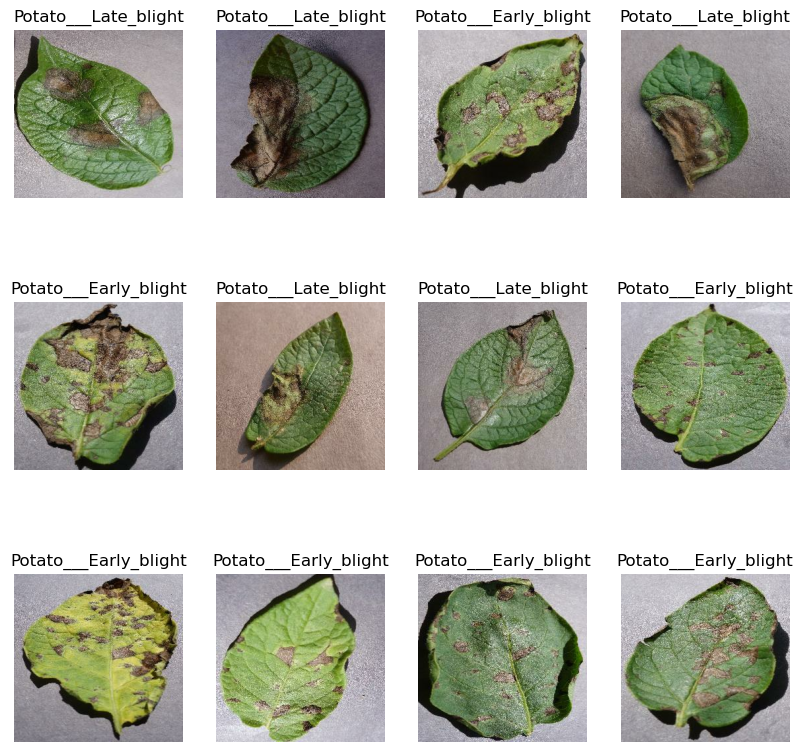

In [108]:
plt.figure(figsize=(10,10))
for image_batch , label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [109]:
# #for image train test and validation split

# import pandas as pd
# from sklearn.model_selection import train_test_split
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [110]:

# # Convert TensorFlow Dataset object into arrays
# data = list(dataset.as_numpy_iterator())
# file_paths = [x[0] for x in data]
# labels = [x[1] for x in data]

# # Create a DataFrame from the arrays
# df = pd.DataFrame({'file_path': file_paths, 'label': labels})

# # Split the DataFrame into train/validation/test sets
# train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
# train_df, validation_df = train_test_split(train_df, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2


In [111]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [112]:

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [113]:
#Cache, Shuffle, and Prefetch the Dataset

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [114]:
#resizing model to resize any image which is not 256 256
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [115]:

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [116]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [117]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (32, 60, 60, 64)         

In [118]:
model.compile(
    optimizer ='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [119]:
history= model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/5
54/54 [==============================] - 34s 615ms/step - loss: 0.9167 - accuracy: 0.4659 - val_loss: 0.9038 - val_accuracy: 0.5208
Epoch 2/5
54/54 [==============================] - 35s 648ms/step - loss: 0.7428 - accuracy: 0.6557 - val_loss: 0.8287 - val_accuracy: 0.5833
Epoch 3/5
54/54 [==============================] - 38s 701ms/step - loss: 0.5385 - accuracy: 0.7616 - val_loss: 0.5687 - val_accuracy: 0.7500
Epoch 4/5
54/54 [==============================] - 38s 704ms/step - loss: 0.3751 - accuracy: 0.8536 - val_loss: 0.2754 - val_accuracy: 0.9010
Epoch 5/5
54/54 [==============================] - 41s 760ms/step - loss: 0.2549 - accuracy: 0.8935 - val_loss: 0.3389 - val_accuracy: 0.8958


In [120]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 3s 203ms/step - loss: 0.2372 - accuracy: 0.8984


In [121]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 54}

In [122]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [123]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.9166939854621887,
 0.7427951693534851,
 0.5384999513626099,
 0.3750879764556885,
 0.2548833191394806]

In [124]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

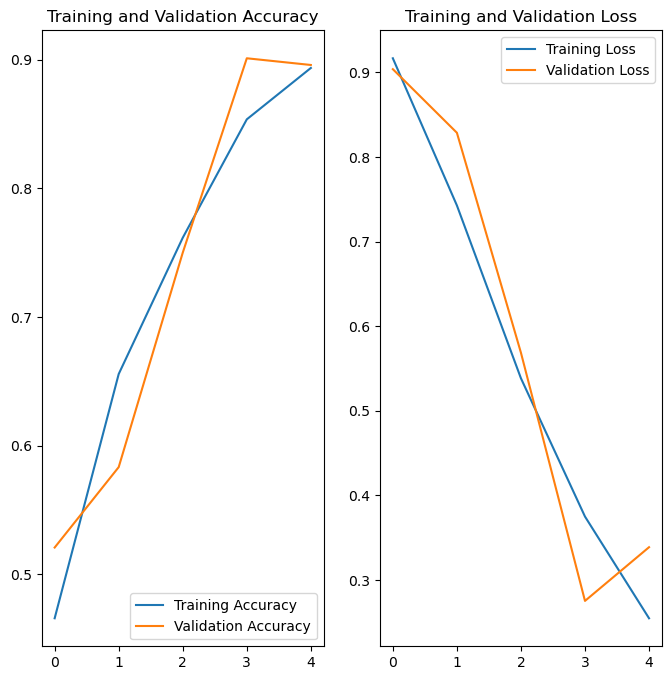

In [125]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<h2> running prediction in test data <h2>
    

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 234ms/step
predicted label: Potato___Late_blight


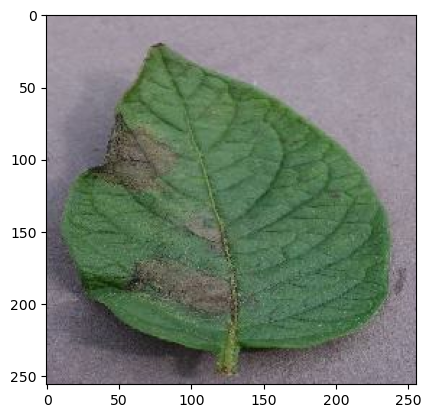

In [126]:

import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [127]:
# function for inference 
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 16ms/step


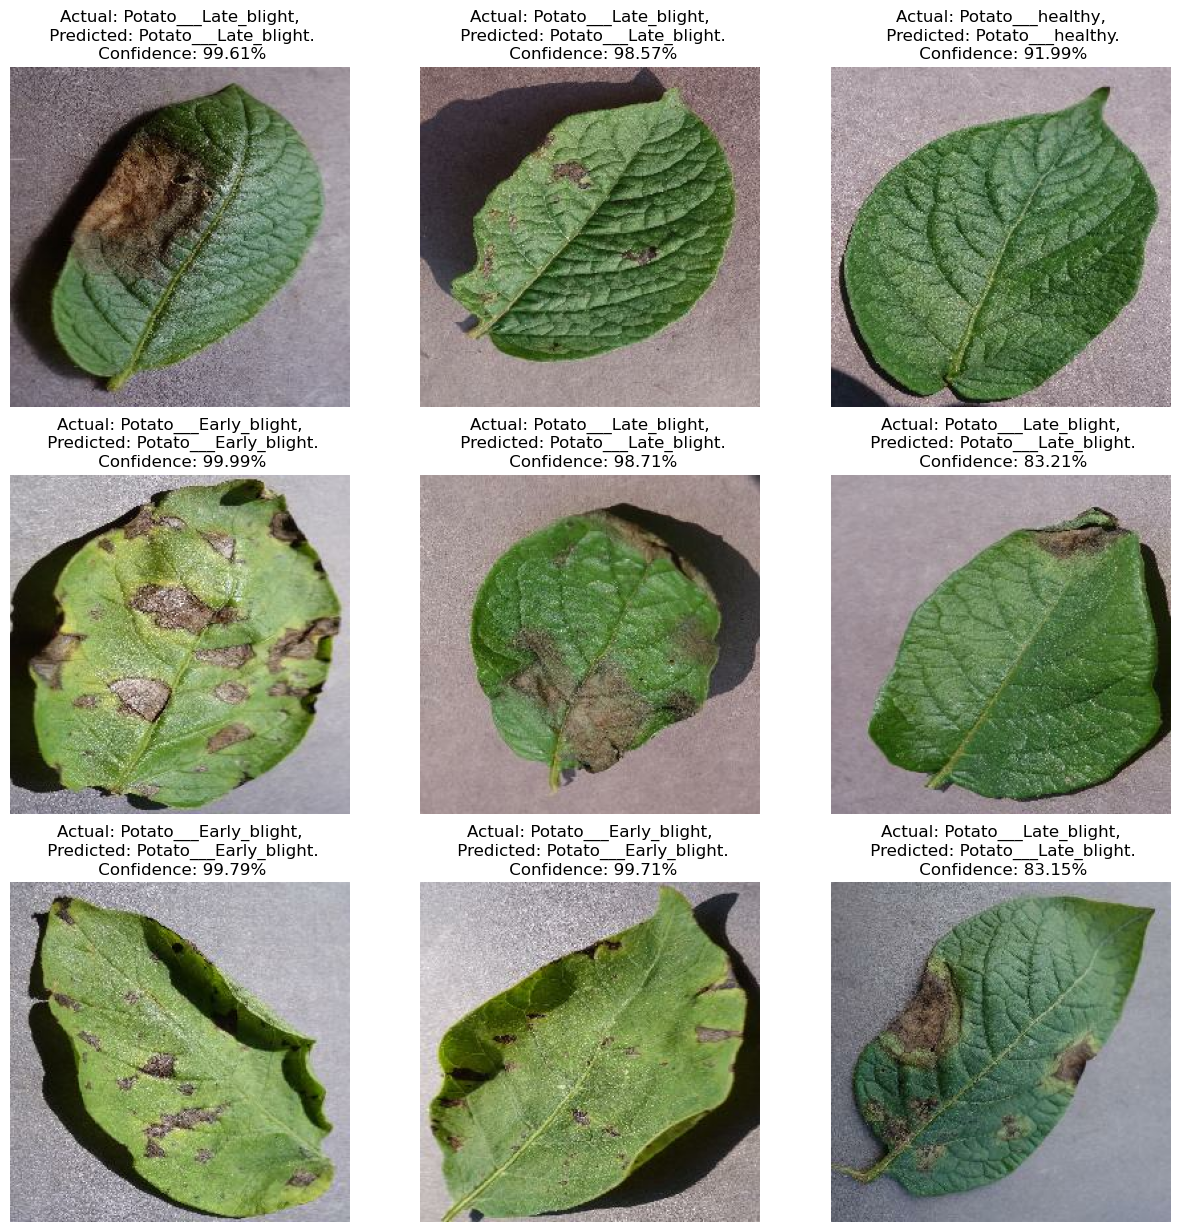

In [128]:
#running inference on few sample of images
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [129]:
#saving the model
import os
model_version=max([int(i) for i in os.listdir("models") + [0]])+1
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/2/assets


INFO:tensorflow:Assets written to: models/2/assets


In [130]:
model.save("../potatoes.h5")

/Users/patrick/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
